In [15]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from numpy.lib.stride_tricks import as_strided
from itertools import product
import time

tStart = time.time()

## Func

In [16]:
def _pad(X, k):
    XX_shape = tuple(np.subtract(X.shape, k.shape) + (1, 1))
    if XX_shape!=X.shape:
        P = np.subtract(X.shape, XX_shape) // 2
        MD = np.subtract(X.shape, XX_shape) % 2
        X_ = np.pad(X, ((P[0], P[0]+MD[0]), (P[1], P[1]+MD[1])), 'constant')
    else:
        X_ = X
    return X_

def _DSP(X, k, iter=1):
    for i in range(iter):
        k_ = k / (k.shape[0] * k.shape[1])
        X_pad = _pad(X, k_)
        view_shape = tuple(np.subtract(X_pad.shape, k_.shape) + 1) + k_.shape
        strides = X_pad.strides + X_pad.strides
        sub_matrices = as_strided(X_pad, view_shape, strides) 
        cv = np.einsum('klij,ij->kl', sub_matrices, k_)
        X = cv[::2, ::2]
    return X

def _USP(DP, k, iter=1):
    for i in range(iter):
        DP_ = np.insert(DP, range(DP.shape[0]), 0, axis=0)
        X = np.insert(DP_, range(DP.shape[1]), 0, axis=1)
        k_ = k / (k.shape[0] * k.shape[1])
        X_pad = _pad(X, k_)
        view_shape = tuple(np.subtract(X_pad.shape, k_.shape) + 1) + k_.shape
        strides = X_pad.strides + X_pad.strides
        sub_matrices = as_strided(X_pad, view_shape, strides) 
        DP = np.einsum('klij,ij->kl', sub_matrices, k_)
    return DP

def _nor(X, h, w):
    X_ = X - np.sum(X) / (h*w)
    return X_

def _CC(X, Y):
    res = np.sum(X * Y) / np.sqrt(np.sum(X**2) * np.sum(Y**2))
    return res

def _sub(I, T):
    view_shape = tuple(np.subtract(I.shape, T.shape) + 1) + T.shape
    strides = I.strides + I.strides
    sub_matrices = as_strided(I, view_shape, strides)
    return sub_matrices

def _match(sub_matrices, T):
    h_, w_, h, w = sub_matrices.shape
    L = []
    T_ = _nor(T, h, w)
    for y, x in product(range(h_), range(w_)):
        S_ = _nor(sub_matrices[y, x, :, :], h, w)
        L.append(_CC(T_, S_))
    res = np.array(L).reshape(h_, w_)
    return res

def _split(path, img_type='100'):
    tot_list = os.listdir(path)
    img_list, tpl_list = [], []
    for j in tot_list:
        k = j.replace('.', '-')
        if k.split('-')[0]==img_type and k.split('-')[-2]!='MatchResult':
            if k.split('-')[-2]=='Template':
                tpl_list.append(j)
            else:
                img_list.append(j)
    return img_list, tpl_list

def _NMS(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")  

def _getBox(res, T_org, thrs):
    M = np.where(res>thrs, 1, 0) 
    box_i, box_j = np.where(M!=0)
    h, w = T_org.shape
    boxes = np.vstack([box_j - w//2, box_i - h//2,\
                box_j + w//2, box_i + h//2]).T
    box_res = _NMS(boxes, 0.4)
    return box_res  

def _plotBox(I_org, box_res):
    I_box_R = cv2.cvtColor(I_org, cv2.COLOR_GRAY2BGR)
    for i in range(len(box_res)):
        x1, y1 = box_res[i, :2]
        x2, y2 = box_res[i, 2:]
        mid_x, mid_y = (x1 + x2) // 2, (y1 + y2) // 2
        text_X = 'X: ' + str(mid_x)
        text_Y = 'Y: ' + str(mid_y)
        cv2.rectangle(I_box_R, (x1, y1), (x2, y2), (0, 0, 255), 1)
        cv2.putText(I_box_R, text_X, (mid_x, mid_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.putText(I_box_R, text_Y, (mid_x, mid_y+45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 1, cv2.LINE_AA)
    return I_box_R    

## path

In [17]:
path = '../img'
img_list, tpl_list = _split(path, img_type='100')

## img

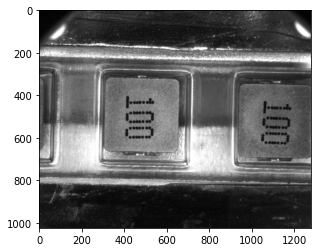

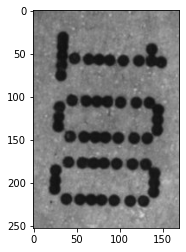

In [18]:
img_org = cv2.imread(os.path.join(path, img_list[1]))
tpl = cv2.imread(os.path.join(path, tpl_list[0]))

fig = plt.figure()
plt.imshow(img_org)

fig = plt.figure()
plt.imshow(tpl)

## View

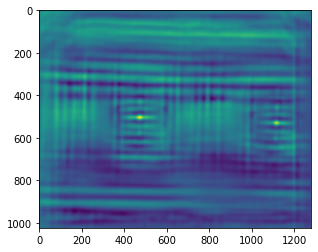

In [19]:
I_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
T_org = cv2.cvtColor(tpl, cv2.COLOR_BGR2GRAY)

G = np.array([[1,  4,  6,  4, 1],
              [4, 16, 24, 16, 4],
              [6, 24, 36, 24, 6],
              [4, 16, 24, 16, 4],
              [1,  4,  6,  4, 1]])
I = _DSP(I_org, G/16, iter=3)
T = _DSP(T_org, G/16, iter=3)
I_pad = _pad(I, T)

sub_matrices = _sub(I_pad, T)
CC = _match(sub_matrices, T)

res = _USP(CC, G/4, iter=3)

fig = plt.figure()
plt.imshow(res)


## Boxes

In [20]:
# Die 0.2
# 100 0.12
box_res = _getBox(res, T_org, 0.12)


## NMS


It cost 1.3043 sec


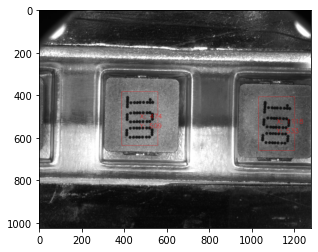

In [21]:
I_box_R = _plotBox(I_org, box_res)

fig = plt.figure()
plt.imshow(cv2.cvtColor(I_box_R, cv2.COLOR_BGR2RGB))

tEnd = time.time()
print ("\n" + "It cost {:.4f} sec" .format(tEnd-tStart))